## NABILA YUMNA NAAFI'A
## 23/511456/PA/21799
----

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle



### Load Dataset

In [159]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

In [160]:
dataset_dir = 'images'
images = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
    if len(files) == 0:
        continue
    for f in files:
        _, image = load_image(os.path.join(root, f))
        if image is None:
            continue
        images.append(image)
        labels.append(root.split('/')[-1])

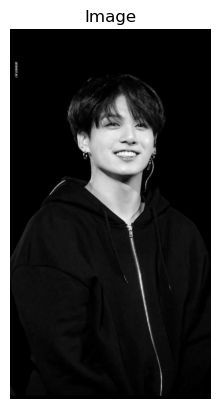

In [ ]:
# Display the first image in the list
if len(images) > 0:
    image = images[13]  # Change the index to view other images
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image")
    plt.axis('off')  # Hide axes for better visualization
    plt.show()
else:
    print("No images to display.")

### Face Detection

In [163]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [164]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    return faces

In [165]:
detect_faces(images[14])


array([[253, 145, 252, 252]])

In [166]:
detect_faces(image)


array([[294, 240, 281, 281]])

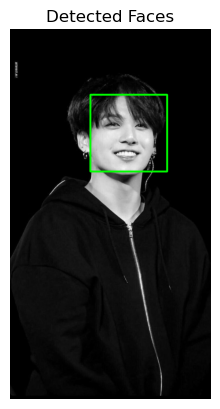

In [167]:
# Convert grayscale image to BGR to ensure colored rectangles are visible
if len(image.shape) == 2:  # Check if the image is grayscale
    image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
else:
    image_copy = np.copy(image)

# Draw green rectangles around detected faces with thicker lines
for (x, y, w, h) in detect_faces(image):
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 5)  # Green color in BGR, thickness = 5

# Display the image with detected faces
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title("Detected Faces")
plt.axis('off')  # Hide axes for better visualization
plt.show()

#### Cropping Faces

In [168]:
def crop_faces(image_gray, faces, return_all=False):
    cropped_faces = []
    selected_faces = []
    if len(faces) > 0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(image_gray[y:y+h, x:x+w])  # Removed the third index
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(image_gray[y:y+h, x:x+w])  # Removed the third index
    return cropped_faces, selected_faces

# show the cropped face
cropped_faces, selected_faces = crop_faces(image, detect_faces(image))

In [169]:
cropped_faces[0]

array([[ 6,  5,  9, ...,  0,  0,  0],
       [ 6,  5,  4, ...,  0,  0,  0],
       [ 6,  6,  1, ...,  0,  0,  0],
       ...,
       [ 2,  3, 12, ...,  0,  0,  0],
       [ 2,  3,  9, ...,  0,  0,  0],
       [ 1,  2, 14, ...,  0,  0,  0]], dtype=uint8)

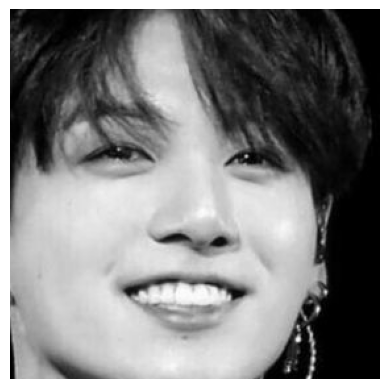

In [170]:
# show the rgb image
plt.imshow(cv2.cvtColor(cropped_faces[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### Face Recognition -- Eigenface

#### Resize and Flatten Face

In [171]:
face_size = (128, 128)

def resize_and_flatten(face):
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()
    return face_flattened

# show/open the flattened image
face_flattened = resize_and_flatten(cropped_faces[0])
face_flattened


array([ 5,  5, 17, ...,  0,  0,  0], dtype=uint8)

In [172]:
#ount the images
len(images), len(labels)
# list(zip(images, labels))

(70, 70)

#### Prepare Training and Testing Data

In [174]:
X = []  # Keep X as a list during the loop
y = []  # Keep y as a list during the loop

# Track images with no detected faces
no_faces_detected = []

for image, label in zip(images, labels):
    faces = detect_faces(image)
    if len(faces) == 0:
        no_faces_detected.append(label)  # Log the label of the image
        continue
    cropped_faces, _ = crop_faces(image, faces)
    if len(cropped_faces) > 0:
        face_flattened = resize_and_flatten(cropped_faces[0])
        X.append(face_flattened)  # Append to the list
        y.append(label)          # Append to the list

# Convert to NumPy arrays after the loop
X = np.array(X)
y = np.array(y)

# Print the labels of images with no detected faces
print("Images with no detected faces:", no_faces_detected)

Images with no detected faces: ['images\\Jungkook', 'images\\Jungkook', 'images\\Jungkook', 'images\\Lalisa', 'images\\Lalisa']


In [176]:
X.shape, y.shape

((65, 16384), (65,))

There is indication that eigenface did not detect the faces of 5 images.

In [ ]:
#import train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# for each split show the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45, 16384), (20, 16384), (45,), (20,))

#### Mean Centering 

To improve feature representation

In [ ]:
class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_face = np.mean(X, axis=0)
        return self

    def transform(self, X):
        return X - self.mean_face

#### Extract Eigenfaces and Build Classifier

In [ ]:
pipe = Pipeline([
    ('centering', MeanCentering()),
    ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
    ('svc', SVC(kernel='linear', random_state=177))
])

#### Train and Evaluate the Model

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

  images\George_W_Bush       0.40      0.67      0.50         3
       images\Jungkook       0.00      0.00      0.00         2
         images\Lalisa       0.50      0.67      0.57         3
     images\Laura_Bush       1.00      0.67      0.80         3
         images\Nabila       0.67      0.67      0.67         3
images\Serena_Williams       0.75      1.00      0.86         3
 images\Vladimir_Putin       0.50      0.33      0.40         3

              accuracy                           0.60        20
             macro avg       0.55      0.57      0.54        20
          weighted avg       0.57      0.60      0.57        20



c:\Users\nabil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nabil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nabil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Visualizing Eigenfaces

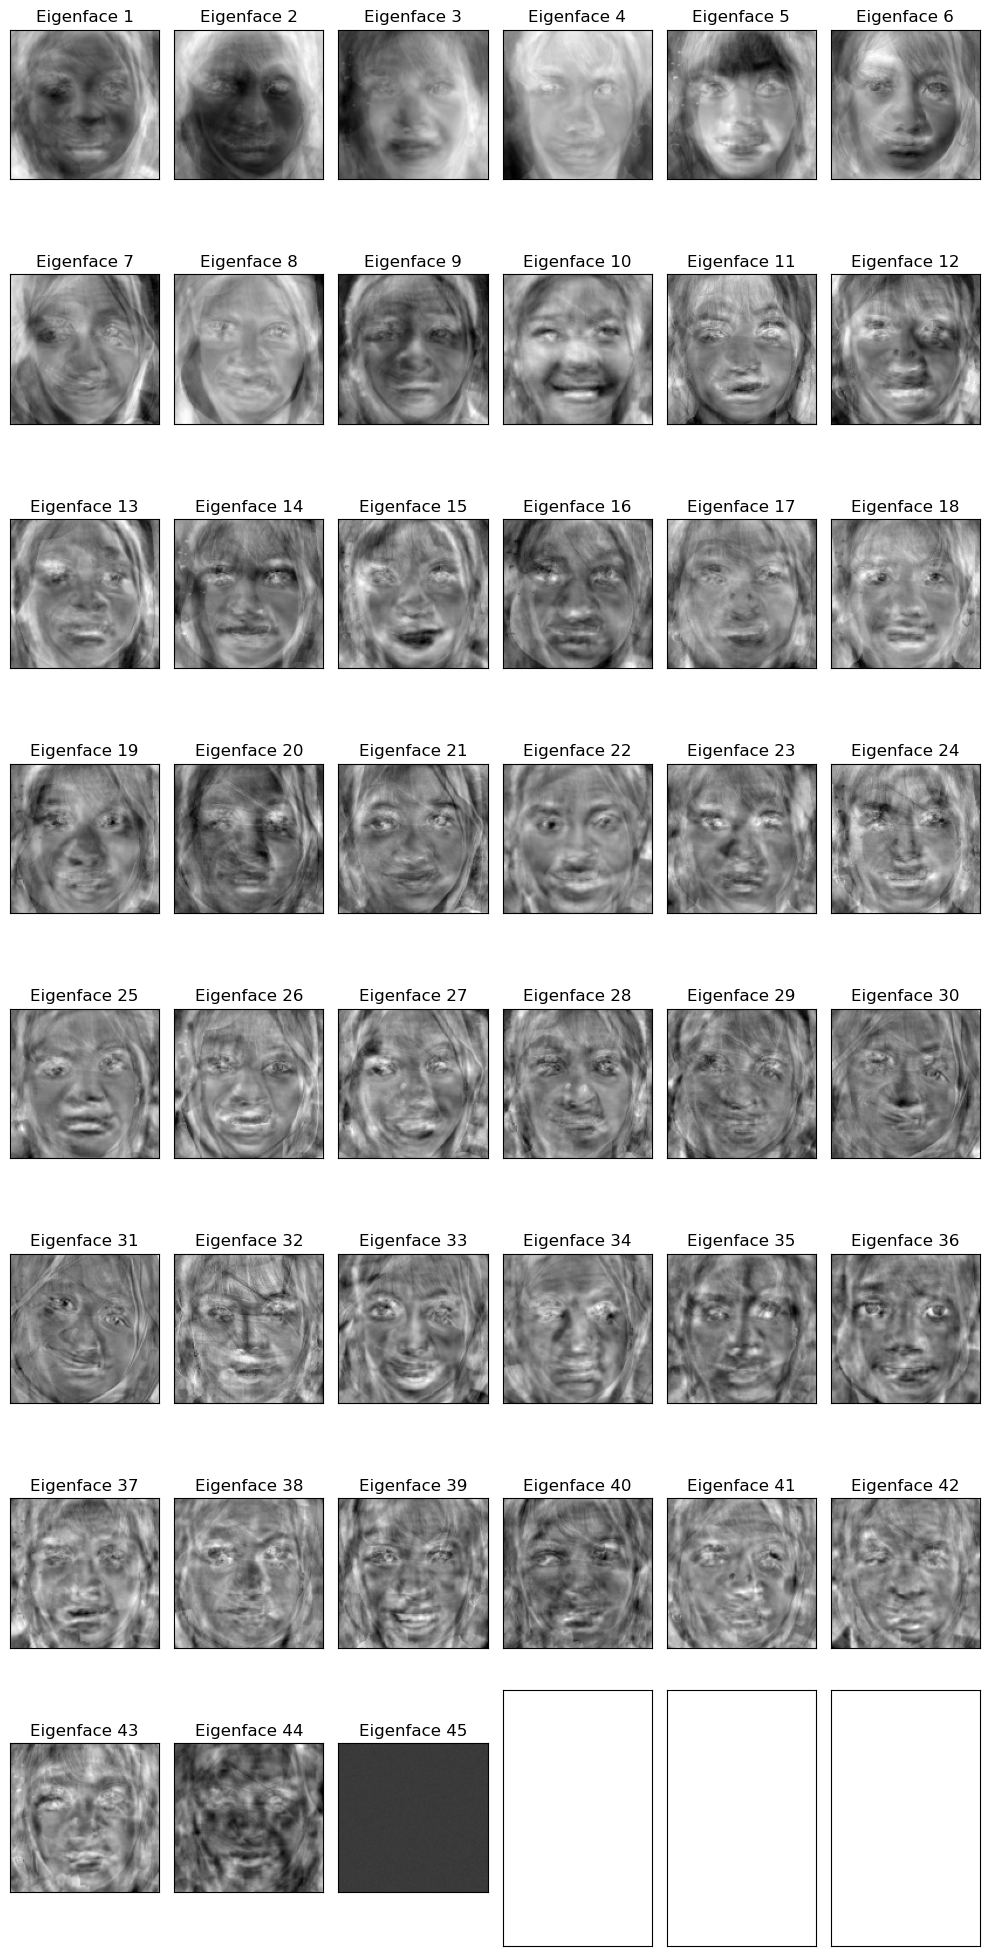

In [190]:
n_components = len(pipe[1].components_)
ncol = 6
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5 * nrow),
                         subplot_kw={'xticks': [], 'yticks': []})
eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))

# Loop only over the available eigenfaces
for i, ax in enumerate(axes.flat[:n_components]):  # Limit to n_components
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()

plt.show()

#### Save the Model Pipeline

In [ ]:
# with open('eigen_face_assignment.pkl', 'wb') as f:
#     pickle.dump(pipe, f)

#### Combine All Methods

In [ ]:
def get_eigenface_score(X):
    X_pca = pipe[:2].transform(X)
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
    return eigenface_scores

In [ ]:
def eigenface_prediction(image_gray):
    faces = detect_faces(image_gray)
    cropped_faces, selected_faces = crop_faces(image_gray, faces)
    if len(cropped_faces) == 0:
        return 'No face detected.'
    
    X_face = []
    for face in cropped_faces:
        face_flattened = resize_and_flatten(face)
        X_face.append(face_flattened)

    X_face = np.array(X_face)
    labels = pipe.predict(X_face)
    scores = get_eigenface_score(X_face)
    return scores, labels, selected_faces

#### Visualize Result

In [183]:
def draw_text(
    image, label, score,
    font=cv2.FONT_HERSHEY_SIMPLEX,
    pos=(0, 0),
    font_scale=0.6,
    font_thickness=2,
    text_color=(0, 0, 0),
    text_color_bg=(0, 255, 0),
    padding=10,  # Added padding for enhanced margin
    rect_thickness=5  # Thickness of the rectangle border
):
    x, y = pos
    score_text = f'Score: {score:.2f}'
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
    
    # Calculate the rectangle dimensions with padding
    rect_width = max(w1, w2) + 2 * padding
    rect_height = h1 + h2 + 3 * padding
    
    # Draw the background rectangle with enhanced margin and thicker border
    cv2.rectangle(image, (x, y - rect_height), (x + rect_width, y), text_color_bg, rect_thickness)
    
    # Draw the label and score text with padding
    cv2.putText(image, label, (x + padding, y - padding), font, font_scale, text_color, font_thickness)
    cv2.putText(image, score_text, (x + padding, y - h2 - 2 * padding), font, font_scale, text_color, font_thickness)

In [188]:
def draw_result(image, scores, labels, coords):
    result_image = image.copy()
    for (x, y, w, h), label, score in zip(coords, labels, scores):
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 10)
        draw_text(result_image, label, score, pos=(x, y))
    return result_image

#### Trying with another image

In [ ]:
sample_image, sample_gray = load_image("images/Nabila/2.jpg")

In [ ]:
sample_score, sample_labels, sample_face = eigenface_prediction(sample_gray)

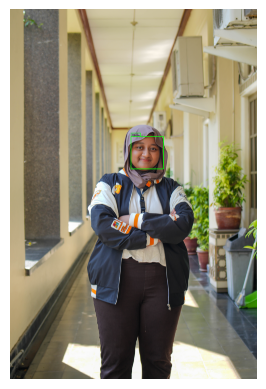

In [189]:
result = draw_result(sample_image, sample_score, sample_labels, sample_face)

# show the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()